# Machine learning using EKF

In [3]:
from IPython import display
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

# Importing Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Select data directory
print("Current Directory:",os.getcwd())
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('..\data/'):
    course_data_dir = '..\data'
else:
    # Specify course_data_dir on your machine
    # course_data_dir = ...
    # YOUR CODE HERE
    raise NotImplementedError()

print('The data directory is %s' % course_data_dir)

Current Directory: D:\Projects\NLP_Project\NeuralNetworkswKalmanFilters\src
The data directory is ..\data


In [5]:
# Select device which you are going to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Import Data Sets
Testing using a toy sine data

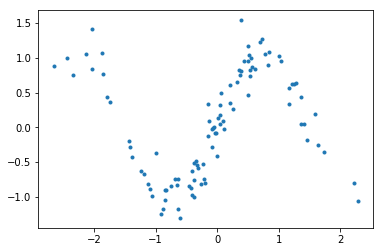

In [6]:
# Let us generate toy data
np.random.seed(2)
x_train = np.random.randn(100, 1)
x_train = np.sort(x_train, axis=0)
y_train = np.sin(x_train * 2 * np.pi / 3)
y_train = y_train + 0.2 * np.random.randn(*y_train.shape)

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x_train, y_train, '.')

In [7]:
## Use MNIST data set
# import packages.mnist.mnist_loader as mnist_loader
# training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# training_data = list(training_data)

## Data Preprocessing


In [8]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

## Define Neural network

In [9]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_layer, n_outputs,bias=True):
        super(MLP, self).__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.fc1 = nn.Linear(n_inputs, n_hidden_layer, bias)
        self.fc2 = nn.Linear(n_hidden_layer, n_hidden_layer, bias)
        self.fc3 = nn.Linear(n_hidden_layer, n_outputs, bias)
        

    def forward(self, x):
        # YOUR CODE HERE
        #raise NotImplementedError()
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x    

In [10]:
## Testing net
n_inputs = 1
n_outputs = 1
n_hidden_layer = 100
test_net = MLP(n_inputs, n_hidden_layer, n_outputs)
print(test_net)

MLP(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


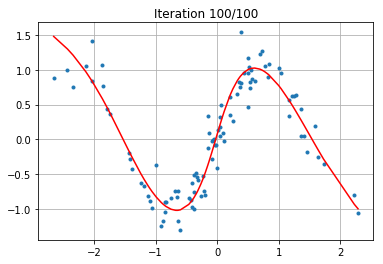

In [11]:
# Define number of Input and Output layers
torch.set_default_dtype(torch.float64)
n_inputs = 1
n_outputs = 1
n_hidden_layer = 10
mlp = MLP(n_inputs,n_hidden_layer, n_outputs)
mpl = mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.005)
n_epochs = 100

train_accuracy_history = []
test_accuracy_history = []

x_train = torch.tensor(x_train, device=device, dtype=torch.float64)
y_train = torch.tensor(y_train, device=device, dtype=torch.float64)

ceLoss = nn.MSELoss()

# Plotting before learning 
fig, ax = plt.subplots(1)
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.')

for epoch in range(n_epochs):
    
    #Set gradients as zero
    mlp.zero_grad()
    #Calculate outputs with forward()
    outputs = mlp(x_train)   
    
    #calculate loss
    loss = ceLoss(outputs, y_train)
#     print(f"The output is :{outputs.item()} expected is :{y_train}")
    #calculate gradients - calling backward()
    loss.backward()
    
    #update weights using optimizer
    optimizer.step()
 
    ax.clear()
    plt_x_train = x_train.cpu().detach().numpy()
    plt_y_train = y_train.cpu().detach().numpy()
    plt_outputs = outputs.cpu().detach().numpy()
    ax.plot(plt_x_train, plt_y_train, '.')
    ax.plot(plt_x_train, plt_outputs, 'r-')
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (epoch+1, n_epochs))
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
display.clear_output(wait=True)

## Using EKF for learning 

In [12]:
# #Calculate Weight size
# weight_mat_size = 0
# for i in range(len(layer_list)-1):
#     weight_mat_size = weight_mat_size + (layer_list[i]*layer_list[i+1])
        
def getWeights(net):
    weight_mat = []
    for name,param in net.named_parameters():
    
        #print('Layer',name, 'is', param.data.shape)
        if (len(list(param.data.shape)) == 2):
            weight_mat.append(param.data.flatten())
        
    weight_mat = torch.cat(weight_mat, dim=0)       
    #print('Shape of weight matrix', weight_mat.shape)
    return weight_mat.view(-1, 1)

def getWeightsgrad(net):
    weight_grad_mat = []
    for name,param in net.named_parameters():
    
        #print('Layer Grads',name, 'is', param.grad.shape)
        if (len(list(param.grad.shape)) == 2):
            weight_grad_mat.append(param.grad.flatten())
        
    weight_grad_mat = torch.cat(weight_grad_mat, dim=0)       
    #print('Shape of weight matrix', weight_grad_mat.shape)   
    return weight_grad_mat.view(-1, 1)

def setWeights(net, weight_mat):
    mem_ind = 0;
    for name,param in net.named_parameters():
        if (len(list(param.data.shape)) == 2):
            #print('Layer',name, 'is', param.data.shape)
            #print(torch.numel(param.data))
            #print(weight_mat[mem_ind:mem_ind+torch.numel(param.data)].view(param.data.shape).shape)
            param.data = weight_mat[mem_ind:mem_ind+torch.numel(param.data)].view(param.data.shape)
            mem_ind = torch.numel(param.data)
    


In [32]:
# Define number of Input and Output layers
torch.set_default_dtype(torch.float64)
n_inputs = 1
n_outputs = 1
n_hidden_layer = 10
mlp_EKF = MLP(n_inputs,n_hidden_layer, n_outputs, bias = False)
mlp_EKF = mlp_EKF.to(device)
n_epochs = 10


# Define EKF covariances
weight_mat = getWeights(mlp_EKF).to(device)
print(f"Shape of W:{weight_mat.shape}")
# System Noise or also known as training  noise  
Q = 1e-6*torch.eye(weight_mat.shape[0],device=device, dtype=torch.float64)
# Measurement noise or noise in targets 
R = 100*torch.eye(n_inputs,device=device, dtype=torch.float64)
#Covariance Matrix
P = 100*torch.eye(weight_mat.shape[0],device=device, dtype=torch.float64)
print(f"Shape of P:{P.shape}")
# setWeights(mlp_EKF, torch.ones(weight_mat.shape).to(device))

print(f"network {mlp_EKF}")
print(weight_mat.shape)
print(x_train.shape)
print(y_train.shape)

Shape of W:torch.Size([120, 1])
Shape of P:torch.Size([120, 120])
network MLP(
  (fc1): Linear(in_features=1, out_features=10, bias=False)
  (fc2): Linear(in_features=10, out_features=10, bias=False)
  (fc3): Linear(in_features=10, out_features=1, bias=False)
)
torch.Size([120, 1])
torch.Size([100, 1])
torch.Size([100, 1])


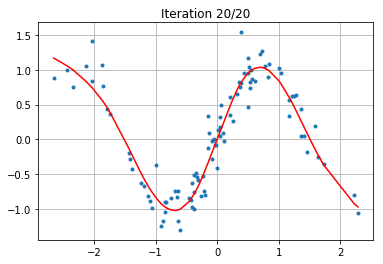

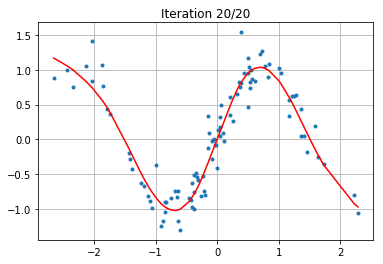

In [33]:
x_train = torch.tensor(x_train, device=device, dtype=torch.float64)
y_train = torch.tensor(y_train, device=device, dtype=torch.float64)

ceLoss = nn.MSELoss(reduction='none')

# Plotting before learning 
fig, ax = plt.subplots(1)
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.')

n_epochs = 20
for epoch in range(n_epochs):
    
    outputs = [] 
    #Calling Backward for each sample
    for i in range((x_train.shape[0])):
#         print(f"sample {i}")
#         print("Weight",getWeights(mlp_EKF).to(device))
        output = mlp_EKF(x_train[i])
        outputs.append(output)
        #print("Update for Batch",i)
        mlp_EKF.zero_grad()
        output.backward(torch.ones_like(output))
        #calculate loss
        #print(output)
        #print(y_train[i,-1])
#         loss = ceLoss(output, y_train[i,-1]).view(1,-1)
#         loss = torch.sqrt(loss)
        loss = (y_train[i,-1]-output).view(1,1)
#         print(f"The output is :{output.item()} expected is :{y_train[i,-1]}")
#         print("Loss", loss.shape)
        #calculate gradients - calling backward()
        #loss.backward()
        # Should be stacked in a for loop for n_outputs > 1
        H = getWeightsgrad(mlp_EKF).to(device).view(1,-1)
#         print("Shape of Weight Grad Mat", H.shape)
#         print(f"Shape of R:{R.shape}")
        #update weights using EKF filter Update
        intermediate = torch.mm(torch.mm(H, P), torch.transpose(H,0,1))
#         print(f"shape of intermediate {intermediate.shape}")
#         print(f"intermediate:{intermediate+R}")
        Ak = torch.inverse(R + intermediate)
#         print(f"shape of Ak:{Ak.shape}")
#         print(f"Ak: {Ak}")
        #Ak = torch.ones(1).view(1,1).to(device)
        Kk = torch.mm(torch.mm(P, torch.transpose(H,0,1)), Ak)
#         print(f"Kk matrix: {Kk}")
        #Kk = torch.ones((120,1)).to(device)
        #print(weight_mat.shape)
        #print("torch.inverse(Shape of Kalman gain",Kk)
        #print("Shape of loss",loss.shape)
        #print("Shape of mul term",torch.mm(Kk, loss).shape)
        #print("Weight Mat Shape",weight_mat)
        weight_mat = getWeights(mlp_EKF).to(device) + torch.mm(Kk, loss)
        #print("Weight Mat Shape",weight_mat.shape)
        P = P + Q - torch.mm(torch.mm(Kk,H),P)
#         print(f"Updated P:{P}")
        setWeights(mlp_EKF,weight_mat)
#     print(f"Epoch loss:{loss}")  
    #print("Weight",weight_mat)
        
    outputs = torch.cat(outputs, dim=0)
    
    #Plotting Output
    ax.clear()
    plt_x_train = x_train.cpu().detach().numpy()
    plt_y_train = y_train.cpu().detach().numpy()
    plt_outputs = outputs.cpu().detach().numpy()
    ax.plot(plt_x_train, plt_y_train, '.')
    ax.plot(plt_x_train, plt_outputs, 'r-')
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (epoch+1, n_epochs))
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
    
# display.clear_output(wait=True)

# Appendix